In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [33]:
config = pymatcal.get_config('../configs/config.yml')
pointA = np.array([5, 5, 0])
cuboid = np.array([5, 5.2, 5, 5.3, -0.5, 0.5, 1, 0.48])
radial_shift = 0.5
det_subs = pymatcal.get_det_subdivcoords(cuboid, config['det nsub'])
subdiv_inc = np.array([config['mmpvx'][0]/config['img nsub']
                      [0], config['mmpvx'][1]/config['img nsub'][1]])
subcentroids = pymatcal.get_img_subdivcoords(config)+pointA
pAs = subcentroids
pBs = det_subs['coords']+np.array([radial_shift, 0, 0])
# pymatcal.get_intersections_2d(np.array([cuboid]), pAs, pBs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)
geoms = np.array([[5.2, 5.3, 5.1, 5.15, -.5, 0.5, 1, 0.48],[5.3, 5.4, 5.0, 5.05, -.5, 0.5, 1, 0.48],[5.3, 5.4, 5.15, 5.2, -.5, 0.5, 1, 0.48]])


In [50]:
ab_vec = abpairs[:, 3:] - abpairs[:, 0:3]
# ab_length = np.linalg.norm(ab_vec,axis=1)
print(ab_vec.shape)
ts = np.array([pymatcal.findt_2d(geom, abpairs) for geom in geoms])
print("ts shape:", ts.shape)
indices = np.all(ts != 0, axis=1)
print("indices shape:", indices.shape)
intersects = np.array(
    [
        [ab_vec.T * ts[iGeom, idx, :] + abpairs[:, 0:3].T for idx in [0, 1]]
        for iGeom in range(0, geoms.shape[0])
    ]
)
print(intersects.shape)
intersects = np.swapaxes(intersects, 3, 1)
print(intersects.shape)
intersects = intersects[indices]
print(intersects.shape)
print

(64, 3)
ts shape: (3, 2, 64)
indices shape: (3, 64)
(3, 2, 3, 64)
(3, 64, 3, 2)
(66, 3, 2)


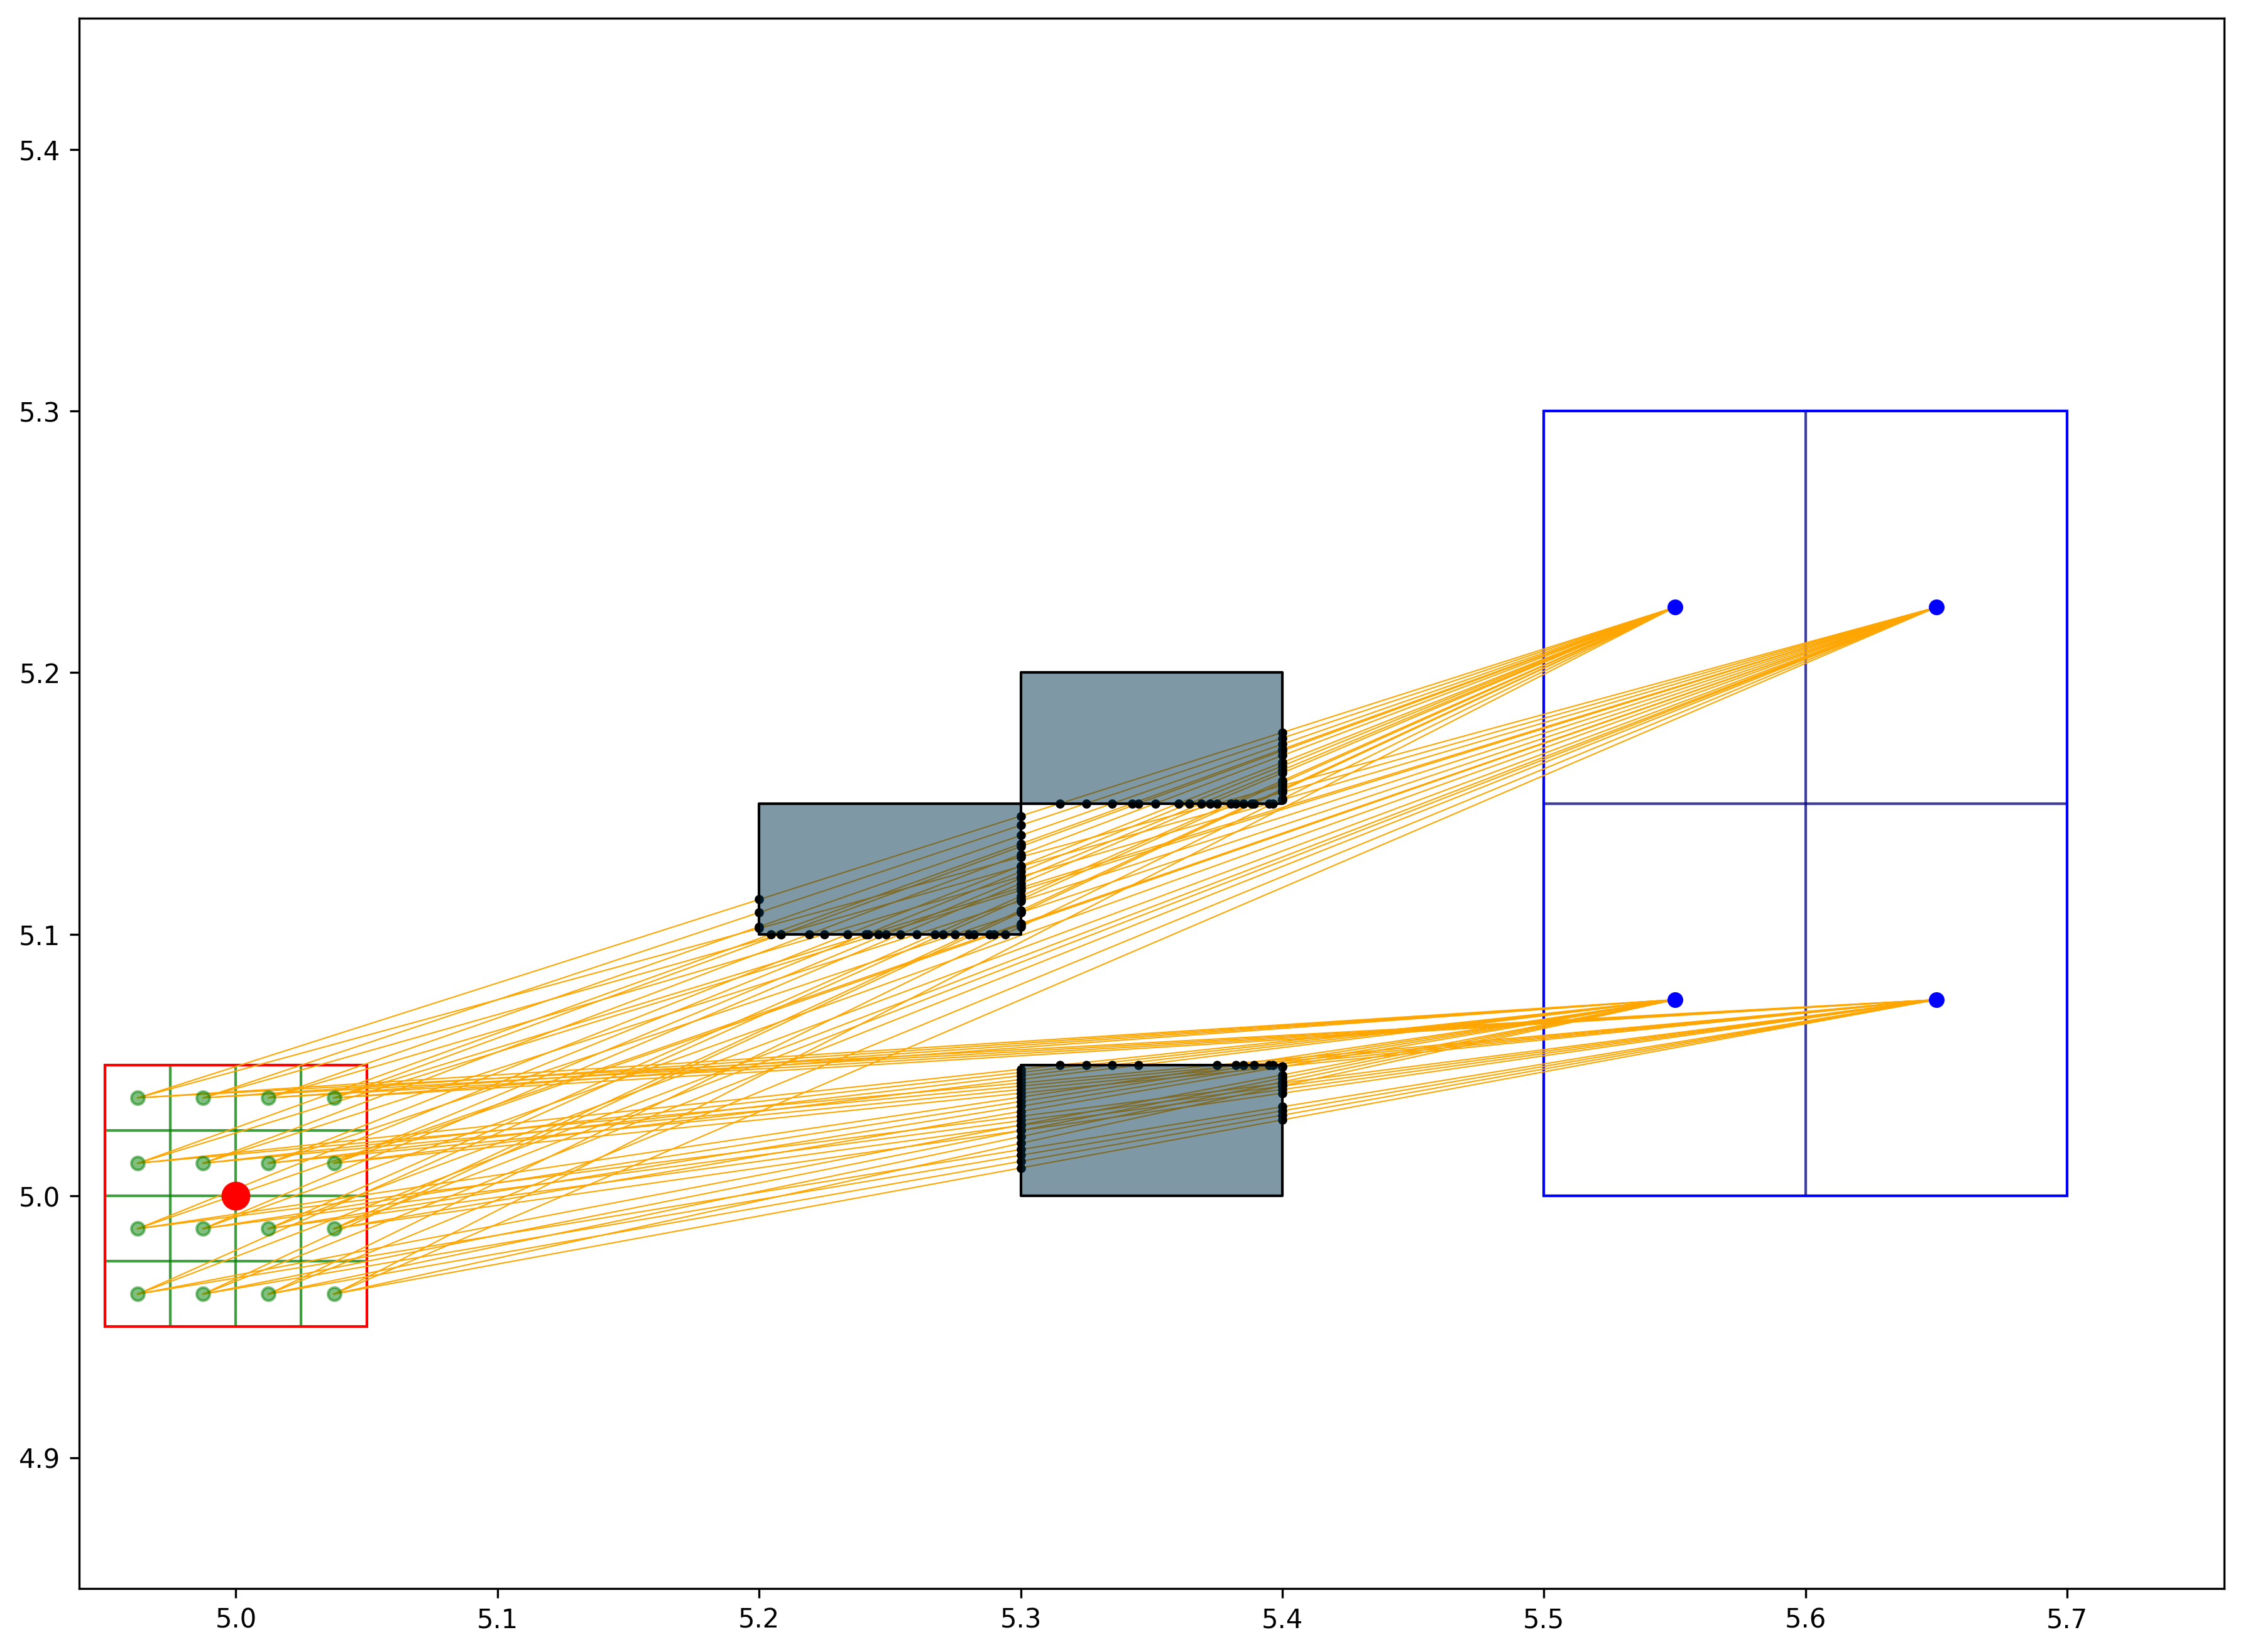

In [55]:
det_subdiv_list = [mpl.patches.Rectangle(
    xy[:2]-det_subs['incs'][:2]*0.5, det_subs['incs'][0], det_subs['incs'][1]) for xy in pBs]

img_subdiv_list = [mpl.patches.Rectangle(
    xy-subdiv_inc*0.5, subdiv_inc[0], subdiv_inc[1]) for xy in subcentroids[:, :2]]
fig, ax = plt.subplots(figsize=(12, 10),dpi=300)
pc = mpl.collections.PatchCollection(
    img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc='none')
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc='none')
nb=pBs.shape[0]
na=pAs.shape[0]
color = plt.cm.rainbow(np.linspace(0, 1, nb))
idx=0
# for pair in abpairs[np.all(ts!=0,axis=0)]:
for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], ',-',c='orange',ms=10,lw=0.5)
    idx +=1

block_list=[mpl.patches.Rectangle(
    (geom[0], geom[2]), geom[1]-geom[0], geom[3]-geom[2]) for geom in geoms]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0,0.2,0.3,0.5), ec='k',zorder=10)
ax.add_collection(pc2)
ax.plot(subcentroids[:, 0], subcentroids[:, 1],
        '.', color=(0, 0.5, 0, 0.5), ms=10)
ax.plot(det_subs['coords'][:, 0]+radial_shift, det_subs['coords'][:, 1],
        '.', color=(0, 0, 1, 1), ms=10)
ax.plot(pointA[0], pointA[1], 'r.', ms=20)
ax.set_xlim(pointA[0]-config['mmpvx'][0]*0.6, pointA[0] +
            config['mmpvx'][0]*.6+radial_shift+cuboid[1]-cuboid[0])
ax.set_ylim(np.min(np.asarray([pointA[1]-config['mmpvx'][1]*0.6, cuboid[2]-0.5*(cuboid[3]-cuboid[2])])),
            np.max(np.asarray([pointA[1]+config['mmpvx'][1]*.6, cuboid[3]+0.5*(cuboid[3]-cuboid[2])])))
ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_patch(mpl.patches.Rectangle(
    (pointA-config['mmpvx']*0.5)[:2], config['mmpvx'][0], config['mmpvx'][1], fc='none', ec='r'))

ax.add_patch(mpl.patches.Rectangle(
    (cuboid[0]+radial_shift, cuboid[2]), cuboid[1]-cuboid[0], cuboid[3]-cuboid[2], fc='none', ec='b'))

ax.set_aspect('equal')
for idx in [0,1]:
    ax.plot(intersects[:,0,idx],intersects[:,1,idx],'k.',ms=5)
fig.tight_layout()
fig.savefig('intersection-2d.png',dpi=300)